### 분자와 타겟 속성을 추출해 중요성 분석

In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
kiba = DTI(name = 'KIBA')

Found local copy...
Loading...
Done!


In [6]:
kiba = pd.DataFrame(kiba.get_data())

affinity와 상관관계가 높은 descriptor TOP 10
Y                   1.000000
EState_VSA8         0.126094
NumAromaticRings    0.124631
EState_VSA4         0.124207
PEOE_VSA8           0.123321
RingCount           0.119982
MolLogP             0.118929
fr_aniline          0.111995
fr_NH1              0.111188
VSA_EState4         0.104603
Name: Y, dtype: float64


KeyboardInterrupt: 

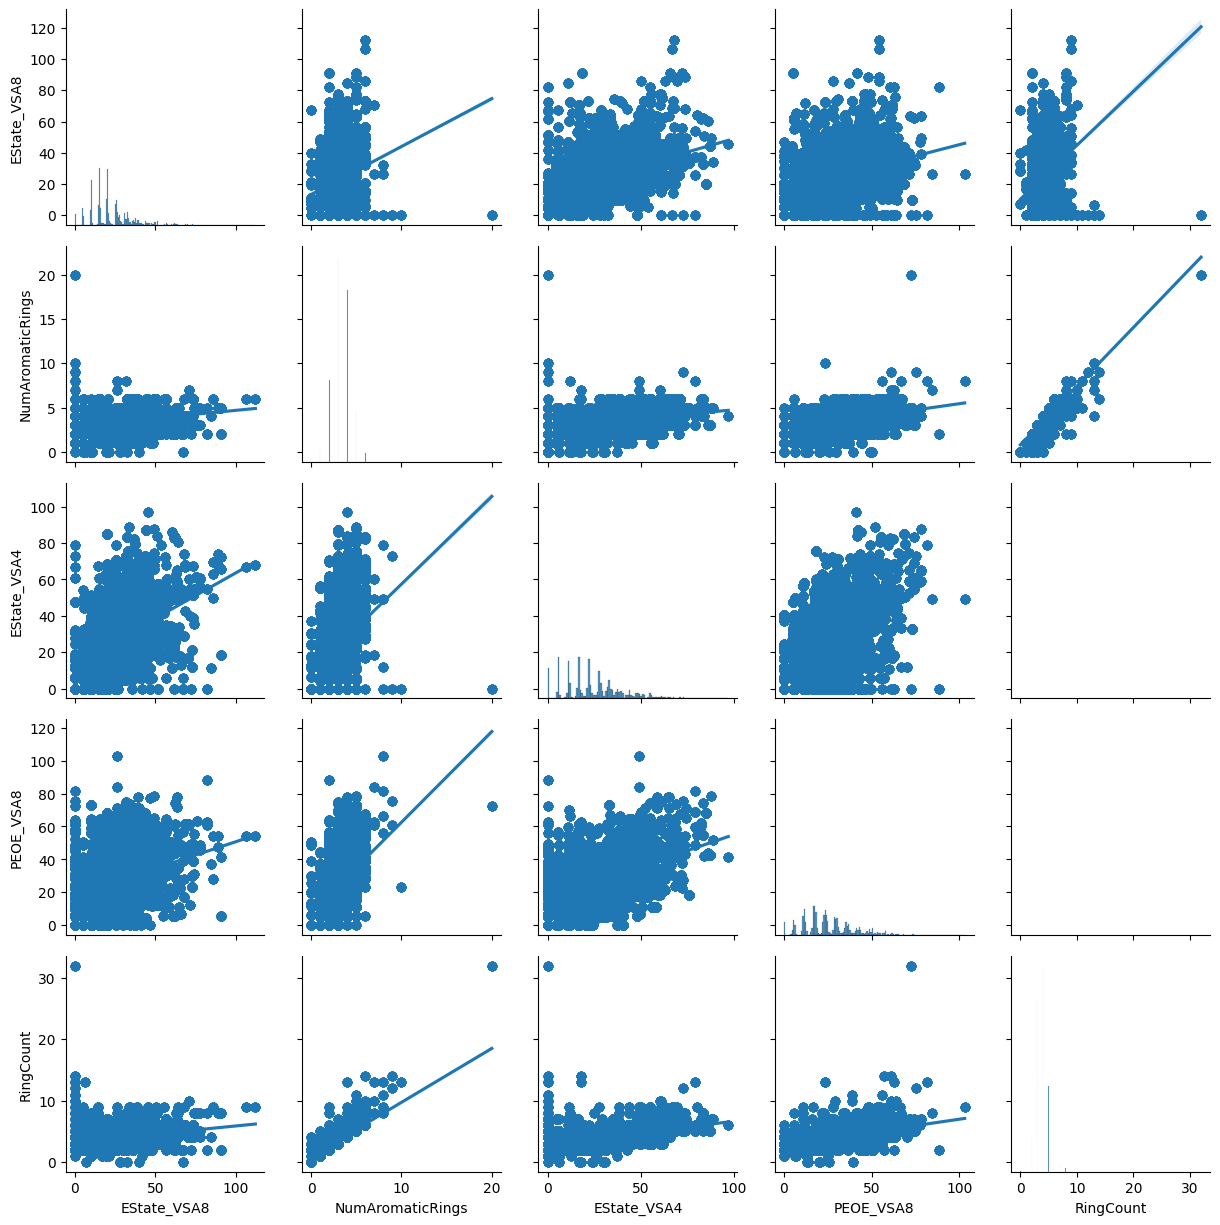

In [8]:
# 2. RDKit descriptor 추출기 준비
descriptor_names = [desc[0] for desc in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

def mol_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * len(descriptor_names)
    return list(calc.CalcDescriptors(mol))

# 3. 각 Drug에 대해 descriptor 계산
desc_df = kiba['Drug'].drop_duplicates().to_frame()
desc_df['descriptors'] = desc_df['Drug'].apply(mol_descriptors)

# descriptors 컬럼을 개별 피처로 분리
desc_features = pd.DataFrame(desc_df['descriptors'].tolist(), 
                             columns=descriptor_names, 
                             index=desc_df['Drug'])

# 원본 데이터에 병합
merged = kiba.merge(desc_features, left_on='Drug', right_index=True)

# 4. 결측치 제거
merged = merged.dropna()

# 5. 상관관계 분석
corr = merged[descriptor_names + ['Y']].corr()['Y'].sort_values(ascending=False)

print("affinity와 상관관계가 높은 descriptor TOP 10")
print(corr.head(10))

# # 6. 시각화 (상관계수 상위 5개만)
# top5 = corr.index[1:6]  # affinity 제외하고 상위 5개
# sns.pairplot(merged, vars=top5, y_vars=['affinity'], kind="reg")
# plt.show()